# Exercises:

## A)

1. Why does the algorithm stop before the density becomes negative? Implement a method to better estimate the surface location and the total Mass of the configuration.

2. Using the odeint() command, test the convergence properties of the system. Try to find ways within python to get better convergence and accuracy. How do different ways of choosing the initial conditions affect the resulting Mass and Radius of the stellar model?

3. Calculate models with different polytropic exponents and compare the mass and density distributions as functions of the radius within the star. One can start by using known EoS cases, beyond the $\Gamma=5/3$ case discussed above. Another approach can be to use a parameterization for the EoS of the form $P=k\rho^{1+1/n}$, and use integer values for $n$ (note that $\Gamma=5/3$ corresponds to $n=3/2$). What do you observe for the mass profiles?

4. In the above presentation we have set all the relevant constants to $1$, which amounts to a specific choice of units. Find a way of making the initial system of equations of structure dimensionless keeping track of the various constants. From there try to infer the physical meaning of some of the parameters, such as the EoS constant $K$. Find the right values and construct a configuration of astrophysical size.   

The algorithm stops because the next step results in a negative density $\rho$ which in turn is in a power thus resulting in an imaginary value for $M$ and $R$. In order to better estimate the edge of the surface of the star we could use the Brent hyperbolic method to find a better estimate for the surface and the total Mass. Thus the code becomes as below

In [15]:
from matplotlib import pyplot as plt    # For plotting things
import numpy as np                      # For mathematical/numerical applications
from scipy.integrate import odeint      # For integrating ODEs
from scipy import optimize              # For the brent root finding
from ipykernel import kernelapp as app
from fractions import Fraction
from IPython.display import display, Math, Latex   # This imports the option of 
                                                 # printing out teX using display()

G=1.0                 # Arbitrary units
K=1.0                 # Arbitrary units
Gamma=5.0/3.0
  
# This defines a function that calculates the derivatives of the system 
# dY/dr = f(Y,r:G,Gamma,K)

def star(y, r, G, Gamma, K):
     return (4.0*np.pi*y[1]*r**2.0, \
             -(G/(K*Gamma))*y[0]*pow(y[1],2.0-Gamma)/r**2.0)   
    
    
def ns_mr(G=1,n=3.0/2.0,K=1,rstart=0.01,rend=3,npoints=101,order=4):
    Gamma = 1+1/n
    r = np.linspace(0, 1, 101)
    y0 = (0.0, 1.0)                # Central values
    dr=rstart #
    y1 = ((4.0/3.0)*np.pi*y0[1]*dr**3.0, \
          y0[1]-(2.0*np.pi*G/(K*Gamma))*pow(y0[1],3.0-Gamma)*dr**2.0)
    ##display(y1)                   # This is our initial guess given by the Taylor expansion

    r1 = np.linspace(dr, rend, npoints)                      # This is an np.array object

    ## define max step as the itteration step
    sol = odeint(star, y1, r1, args=(G, Gamma, K),hmax=(r1[1]-r1[0])/2)    # This is an np.array object
    (Nrow,Ncol) = sol.shape

    if np.isnan(np.sum(sol[:,1])) == True:## check for NaNs
    ##################################
    ### since there are no infinities the maximum value is the first NaN value. 
    ### Get the index to know where the odeint stoped
        first_nan=int(sol[:,1].argmax()) ## index where rho becomes negative
        check = 1
    elif any(sol[:,1]<0) == True:
        first_nan = np.where(sol[:,1]<0)[0][0] ##first negative
        check = 1
    else:
        first_nan = np.argmin(sol[:,1])
        check = 0

        
    if check == 1:
        ##polynomial fit on the last values to get an estimate of the root
        minind = (first_nan-int(order)-1)
        polarray = sol[minind:first_nan] ##Select last 10% of data for fitting without the negative point
        polR = r1[minind:first_nan]

        pmas = np.polyfit(polR,polarray[:,0],order) ## 4th order polynomial fit
        prho = np.polyfit(polR,polarray[:,1],order)

        pfmas = np.poly1d(pmas) ##polynomial function for later evaluation
        pfrho = np.poly1d(prho)

        r0b = optimize.brent(pfrho,brack=(polR[-1],r1[first_nan]))## root finding of polynomial 
        r0t = (polarray[-1,1]*polR[-2]-polarray[-2,1]*polR[-1])/(polarray[-1,1]-polarray[-2,1])##linear fit solution

        ## we know that the NaN point is the first time rho becomes negative.
        ## Therefore the root mast be before that point.
        ## We check if the r0 satisfies this
        if r0b < r1[first_nan] and r0b > polR[-1]: ##if pol root is ok
        ##print("r0b",polR[-1],r0b,r1[first_nan])
            print("4th order polyfit was used")
            r0 = r0b
            Mtot = pfmas(r0)
        elif r0t < r1[first_nan] and r0t > polR[-1]: ## if tangent is ok
            ##print("r0t",polR[-1],r0t,r1[first_nan])
            print("linear fit was used")
            r0 = r0t
            Mtot = ((polarray[-1,0]-polarray[-2,0])*r0+ \
                    (polarray[-2,0]*polR[-1]-polarray[-1,0]*polR[-2]))/(polR[-1]-polR[-2])

        else: ## last bisection
            print("bisection was used")
            r0 = (polR[-1]+r1[first_nan])/2
            Mtot = ((polarray[-1,0]-polarray[-2,0])*r0+ \
                    (polarray[-2,0]*polR[-1]-polarray[-1,0]*polR[-2]))/(polR[-1]-polR[-2])

            ##print("r0s",polR[-1],r0s,r1[first_nan])
    
        #print('Tangent is',r0t)
        rho_surf = pfrho(r0)
        sol=np.append(sol[0:first_nan],[[Mtot,0]],axis=0)##add root at the end
        sol = np.insert(sol,0,y0,axis=0)##add the first point

        r = np.append(r1[0:first_nan],r0) ## add the surface point
        r = np.insert(r,0,0) ## add first point

    else:
        r = r1
        r = np.insert(r,0,0) ## add first point
        sol = np.insert(sol,0,y0,axis=0)##add the first point
        r0 = r[-1]
        Mtot = sol[-1,0]
        rho_surf = sol[-1,1]
        print('!!!No Star Surface Found!!!')
        
    plt.figure(figsize=(8, 4), dpi=80)

    R_star = r0
    M_star = Mtot
    print('=========Results==========')
    print('N_s')
    print('Gamma =',Fraction(Gamma).limit_denominator(10))
    print('n =',n)
    print('Mass =', M_star)
    print('Radius =', R_star)
    print('rho_s =', rho_surf)
    print('====================================')


    plt.figure(figsize=(10, 5), dpi=80)

    plt.xlim(0.0, R_star+dr) 
    plt.ylim(-0.01, 1.01) 
    tlt = '$n = $'+ str(n)+'$, \Gamma = $'+str(Fraction(Gamma).limit_denominator(10))
    plt.suptitle(tlt, fontsize=18)

    plt.plot(r[:], sol[:, 0]/M_star, 'b', label=r'$m(r)/M$')   # The plots
    plt.plot(r, sol[:, 1], 'g', label=r'$\rho(r)/\rho_c$')      # The plots

    plt.legend(loc='best')
    plt.xlabel('r')
    plt.grid()
    plt.show()


linear fit was used
=========Results==========
N_s
Gamma = 2
n = 1.0
Mass = 2.514351124714611
Radius = 1.2525294101731592
rho_s = 0.000626642156294932


<Figure size 640x320 with 0 Axes>

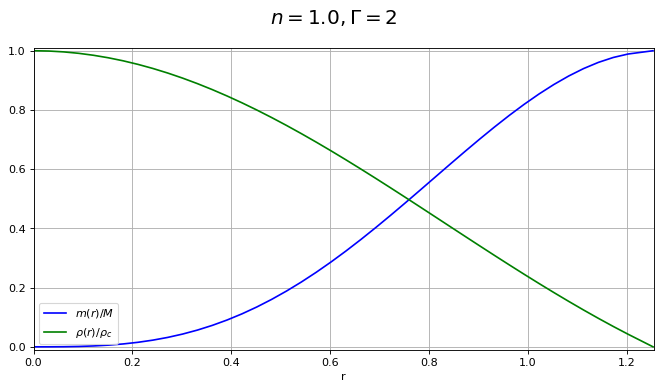

4th order polyfit was used
=========Results==========
N_s
Gamma = 5/3
n = 1.5
Mass = 3.0261611954374175
Radius = 1.6431157824897276
rho_s = -0.00027571716702823323


/home/orion/Documents/MTPX_Computational_2018/Astrophysics/Astro_Jupy/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 640x320 with 0 Axes>

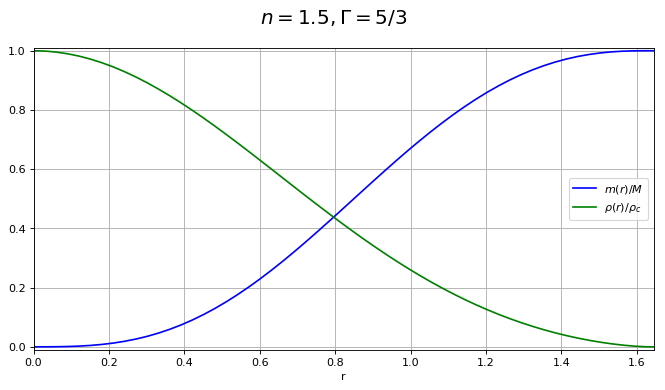

4th order polyfit was used
=========Results==========
N_s
Gamma = 3/2
n = 2.0
Mass = 3.5341251249997345
Radius = 2.1268097868493534
rho_s = 2.8288828612943462e-08


<Figure size 640x320 with 0 Axes>

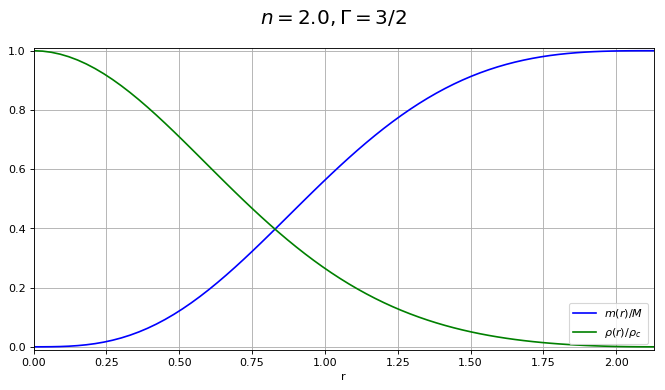

4th order polyfit was used
=========Results==========
N_s
Gamma = 7/5
n = 2.5
Mass = 4.040037402461987
Radius = 2.818540191375658
rho_s = 1.7809646027378e-07


<Figure size 640x320 with 0 Axes>

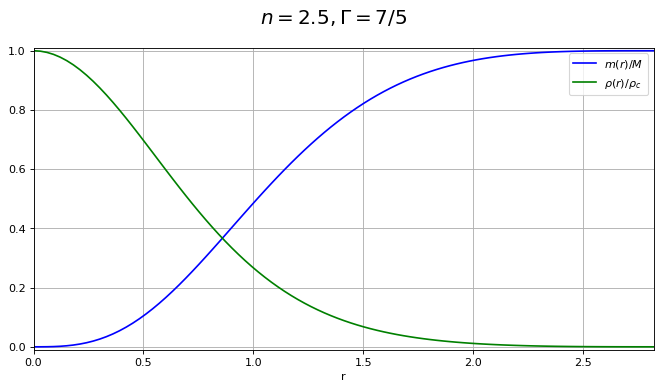

linear fit was used
=========Results==========
N_s
Gamma = 4/3
n = 3.0
Mass = 4.5546709677267305
Radius = 3.8760406828036302
rho_s = 1.4067943060469545e-09


<Figure size 640x320 with 0 Axes>

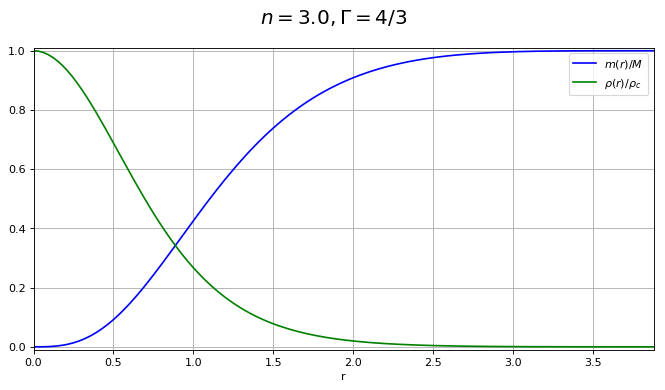

linear fit was used
=========Results==========
N_s
Gamma = 9/7
n = 3.5
Mass = 5.091008665527848
Radius = 5.707395817403595
rho_s = 7.458911960300796e-13


<Figure size 640x320 with 0 Axes>

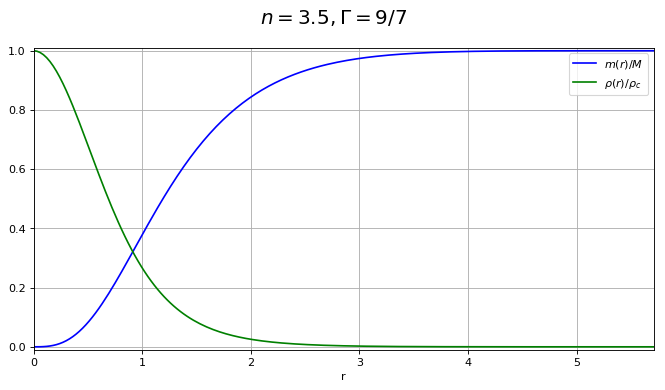

linear fit was used
=========Results==========
N_s
Gamma = 5/4
n = 4.0
Mass = 5.668316223674389
Radius = 9.501154679375572
rho_s = 2.5694425970571033e-14


<Figure size 640x320 with 0 Axes>

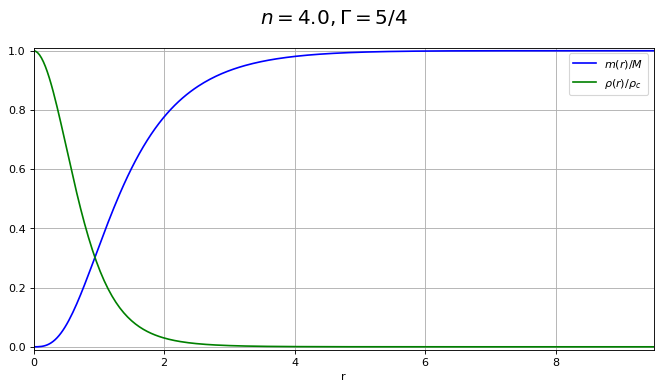

4th order polyfit was used
=========Results==========
N_s
Gamma = 11/9
n = 4.5
Mass = 6.323232001864537
Radius = 21.008236485208368
rho_s = 9.618588511664614e-19


<Figure size 640x320 with 0 Axes>

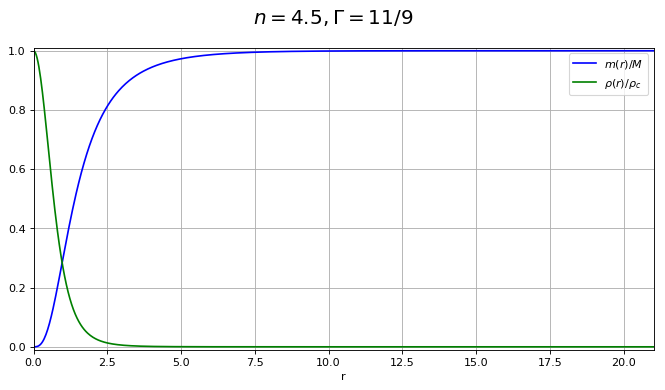

!!!No Star Surface Found!!!
=========Results==========
N_s
Gamma = 6/5
n = 5.0
Mass = 7.163862204794674
Radius = 30.0
rho_s = 1.0065326396446612e-07


<Figure size 640x320 with 0 Axes>

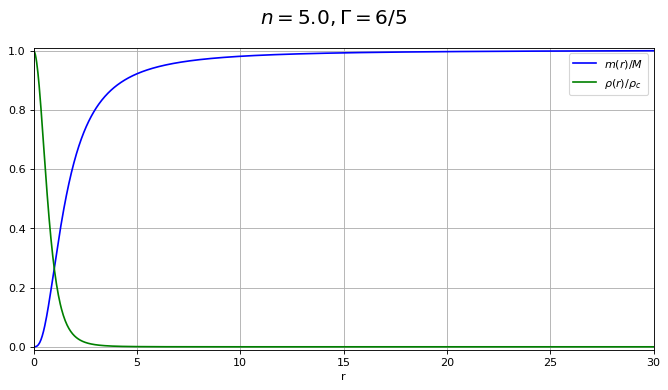

!!!No Star Surface Found!!!
=========Results==========
N_s
Gamma = 7/6
n = 5.5
Mass = 8.380855837794552
Radius = 30.0
rho_s = 1.5899585567078263e-06


<Figure size 640x320 with 0 Axes>

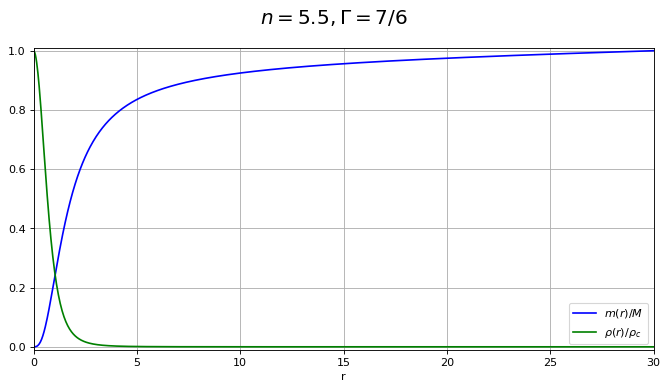

In [16]:
## Plot all the M-R, $\rho - r$ for half-integers 
for i in range(2,12):
    ns_mr(1,i/2.0,1,0.001,30,1000)
    



For $n\ge5$ the density $\rho$ asymptotically approaches $0$. Thus for these models we never actually have a limit in the surface of the star. 

Dimensionless Analysis.

We can set the variables involved in the differential equations to dimensionless variables. this will enable us to solve the problem in its general form and acquire a set of solutions which can later be transformed to dimensional units. Thus let us make the following transformation,

$$m = m_s m',$$
$$r = r_s r',$$
$$\rho = \rho_c (1+\rho')$$


Then the differential equations are written as,

$$\frac{d m'}{d r'} = \frac{4\pi\rho_c r_s^3}{m_s} (\rho' + 1) {r'}^2,$$
$$\frac{d\rho'}{dr'} = -\frac{G m_s \rho_s^{1-\Gamma}}{K \Gamma r_s} \frac{(\rho' + 1)^{2-\Gamma} m'}{{r'}^2} $$

By setting $\frac{4\pi\rho_c r_s^3}{m_s} = 1$ and $\frac{G m_s \rho_s^{1-\Gamma}}{K \Gamma r_s} = 1$ and substituting we end up with the following system of equations,

$$\frac{dm'}{dr'} = (\rho' + 1) {r'}^2,$$
$$\frac{d\rho'}{dr'} = - \frac{(\rho' + 1)^{2-\Gamma} m'}{{r'}^2} $$

with initial conditions as,

$$ m'(0) = 0,$$
$$\rho'(0) = 0.$$

In the above system we have,

$$r_s = \sqrt{\frac{K \Gamma}{4\pi G}\rho_c^{\Gamma-2}},$$
$$m_s = \sqrt{\frac{K^3 \Gamma^3}{4\pi G^3}\rho_c^{3\Gamma-4}},$$


So after solving the system of equation we get $m'$ and $\rho'$ for a given $r'$. Then we can transform them to $m$, $\rho$ and $r$ using $m_s$ and $\rho_c$ and $r_s$. This is one possible way of making the problem dimensionless and not the only one or the best for that matter. 



## Part 2

In [95]:
def starLE(y, r, n, l):
     return (-pow(y[1],n)*r**2.0,l*y[0]*pow(r,-2.0)) 
    
    
    
def ns_mr_le(n=3.0/2.0,rstart=0.01,rend=3.0,npoints=101,order=4):
    l=1
    #r = np.linspace(0, 1, 101)
    y0 = (0.0, 1.0)                # Central values
    dr=rstart #
    y1 = ((-1.0/3.0)*dr**3.0,1.0-(1.0/6.0)*dr**2.0)
   

    r1 = np.linspace(dr, rend, npoints)                      # This is an np.array object

    ## define max step as the itteration step
    solLE = odeint(starLE, y1, r1, args=(n,l),hmax=(r1[1]-r1[0])/2.0)    # This is an np.array object
    (Nrow,Ncol) = solLE.shape

#     if np.isnan(np.sum(solLE[:,1])) == True or any(np.power(solLE[:,1],n)<0) == True:## check for NaNs
#     ##################################
#     ### since there are no infinities the maximum value is the first NaN value. 
#     ### Get the index to know where the odeint stoped
#         if np.isnan(np.sum(solLE[:,1])) == True:
#             first_nan = int(solLE[:,1].argmax()) ## index where rho becomes negative
#         else:
#             first_nan = npoints-1
#         if any(solLE[:,1]<0) == True:
#             first_min = np.where(solLE[:,1]<0)[0][0] ##first negative
#         else:
#             first_min = npoints-1
#         check = 1
#     else:
#         first_nan = np.argmin(solLE[:,1])
#         check = 0

        
        
    if np.isnan(np.sum(solLE[:,1])) == True :## check for NaNs
    ##################################
    ### since there are no infinities the maximum value is the first NaN value. 
    ### Get the index to know where the odeint stoped
        first_nan = int(solLE[:,1].argmax()) ## index where rho becomes negative
        check = 1
    elif np.isnan(np.sum(np.power(solLE[:,1],n))) == True:
        first_nan = int(np.power(solLE[:,1],n).argmax()) ## index where rho becomes negative
        check = 1
    elif any(np.power(solLE[:,1],n)<0) == True:
        first_nan = np.where(np.power(solLE[:,1],n)<0)[0][0] ##first negative
        check = 1
    else:
        first_nan = npoints-1
        check = 0    
        
        
        
        
    if check == 1:
        #print(first_nan)
        #if first_nan >= first_min:
        #    first_nan = first_min ## Check whether min happens before Nan and choose 
        
        ##polynomial fit on the last values to get an estimate of the root
        minind = (first_nan-int(order)-1)
        polarray = solLE[minind:first_nan] ##Select last 10% of data for fitting without the negative point
        polR = r1[minind:first_nan]
        #print(y1,first_nan,polR)
        pmas = np.polyfit(polR,polarray[:,0],order) ## 4th order polynomial fit
        prho = np.polyfit(polR,polarray[:,1],order)

        pfmas = np.poly1d(pmas) ##polynomial function for later evaluation
        pfrho = np.poly1d(prho)

        r0b = optimize.brent(pfrho,brack=(polR[-1],r1[first_nan]))## root finding of polynomial 
        r0t = (polarray[-1,1]*polR[-2]-polarray[-2,1]*polR[-1])/(polarray[-1,1]-polarray[-2,1])##linear fit solution
        #print(r0t)
        ## we know that the NaN point is the first time rho becomes negative.
        ## Therefore the root mast be before that point.
        ## We check if the r0 satisfies this
        if r0b < r1[first_nan] and r0b > polR[-1]: ##if pol root is ok
        ##print("r0b",polR[-1],r0b,r1[first_nan])
            print("4th order polyfit was used")
            r0 = r0b
            Mtot = pfmas(r0)
        elif r0t < r1[first_nan] and r0t > polR[-1]: ## if tangent is ok
            ##print("r0t",polR[-1],r0t,r1[first_nan])
            print("linear fit was used")
            r0 = r0t
            Mtot = ((polarray[-1,0]-polarray[-2,0])*r0+ \
                    (polarray[-2,0]*polR[-1]-polarray[-1,0]*polR[-2]))/(polR[-1]-polR[-2])

        else: ## last bisection
            print("bisection was used")
            r0 = (polR[-1]+r1[first_nan])/2
            Mtot = ((polarray[-1,0]-polarray[-2,0])*r0+ \
                    (polarray[-2,0]*polR[-1]-polarray[-1,0]*polR[-2]))/(polR[-1]-polR[-2])

            ##print("r0s",polR[-1],r0s,r1[first_nan])
    
        
        rho_surf = pfrho(r0)
        solLE =np.append(solLE[0:first_nan],[[Mtot,0]],axis=0)##add root at the end
        solLE = np.insert(solLE,0,y0,axis=0)##add the first point

        r = np.append(r1[0:first_nan],r0) ## add the surface point
        r = np.insert(r,0,0) ## add first point

    else:
        r = r1
        r = np.insert(r,0,0) ## add first point
        solLE = np.insert(solLE,0,y0,axis=0)##add the first point
        r0 = r[-1]
        Mtot = solLE[-1,0]
        rho_surf = solLE[-1,1]
        print('!!!No Star Surface Found!!!')
        
    #plt.figure(figsize=(8, 4), dpi=80)
    
    R_star = r0
    M_star = Mtot

    return (r,solLE)







!!!No Star Surface Found!!!


<IPython.core.display.Math object>

linear fit was used


/home/orion/Documents/MTPX_Computational_2018/Astrophysics/Astro_Jupy/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/orion/Documents/MTPX_Computational_2018/Astrophysics/Astro_Jupy/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


<IPython.core.display.Math object>

linear fit was used


<IPython.core.display.Math object>

linear fit was used


<IPython.core.display.Math object>

bisection was used


<IPython.core.display.Math object>

linear fit was used


<IPython.core.display.Math object>

linear fit was used


<IPython.core.display.Math object>

linear fit was used


<IPython.core.display.Math object>

bisection was used


<IPython.core.display.Math object>

bisection was used


<IPython.core.display.Math object>

!!!No Star Surface Found!!!


<IPython.core.display.Math object>

!!!No Star Surface Found!!!


<IPython.core.display.Math object>

!!!No Star Surface Found!!!


<IPython.core.display.Math object>

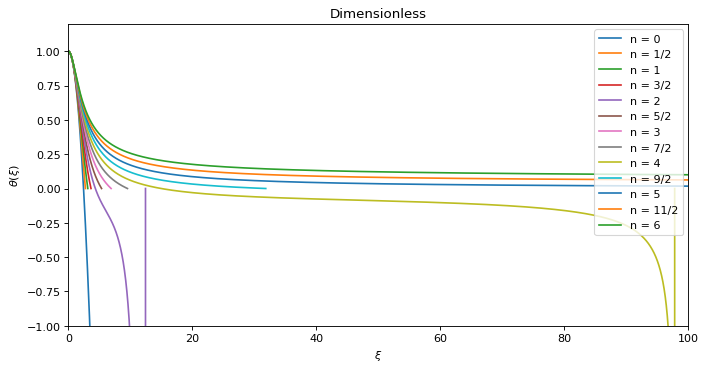

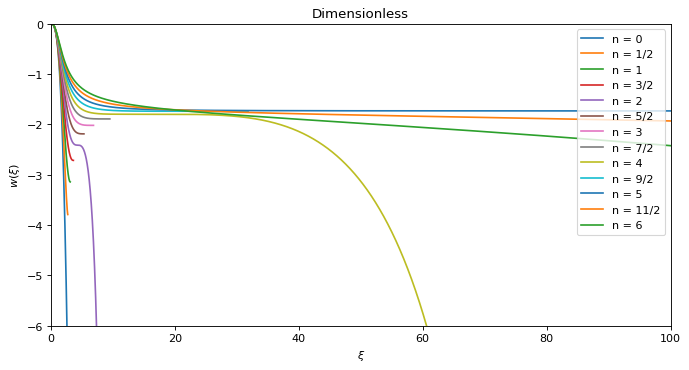

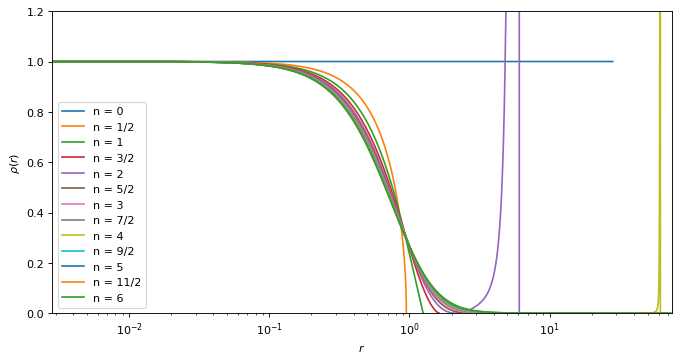

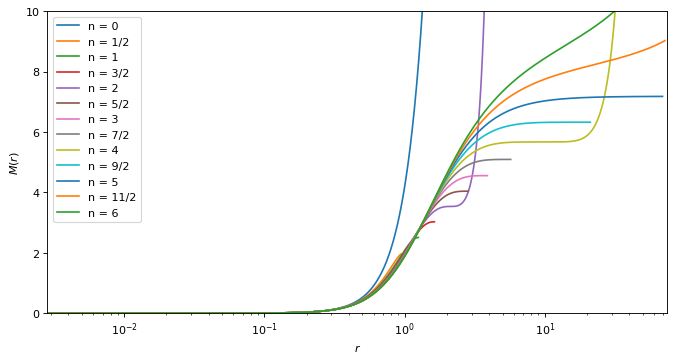

In [98]:
%matplotlib inline
plt.clf
fig1=plt.figure(figsize=(10, 5), dpi=80)
fig2=plt.figure(figsize=(10, 5), dpi=80)
ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)
fig3=plt.figure(figsize=(10, 5), dpi=80)
fig4=plt.figure(figsize=(10, 5), dpi=80)
ax3 = fig3.add_subplot(111)
ax4 = fig4.add_subplot(111)
rlimit=100
np.seterr(all='ignore')#supress numpy error output
for i in range(0,13):
    n = i/2.0
    [rw,solw] = ns_mr_le(n,0.01,rlimit,10001,3)
    lstr = 'n = '+str(Fraction(i/2).limit_denominator(10))#+', $\Gamma$ = '\
        #+str(Fraction(1+2/i).limit_denominator(10))
    ## Setting Dimensional units
    alpha = np.sqrt((n+1)/(4*np.pi))
    R1 = alpha*rw
    rho1 = np.power(solw[:,1],n)
    M1 = -4*np.pi*solw[:,0]*alpha**3
    #print(rho1)
    #Plotting Dimensionless units
    ax1.plot(rw,solw[:,1],label=lstr);
    ax1.set_xlim(0,rlimit)
    ax1.set_ylim(-1,1.2)
    ax1.set_ylabel(r"$\theta(\xi)$")
    ax1.set_xlabel(r"$\xi$")
    ax1.set_title('Dimensionless')
    
    ax2.plot(rw,solw[:,0],label=lstr);
    ax2.set_xlim(0,rlimit)
    ax2.set_ylim(-6,0)
    ax2.set_ylabel(r"$w(\xi)$")
    ax2.set_xlabel(r"$\xi$")
    ax2.set_title('Dimensionless')
    
    #Plotting Dimensional units
    ax3.plot(R1,rho1,label=lstr)
    ax3.set_xlim(0,alpha*rlimit)
    ax3.set_ylim(0,1.2)
    ax3.set_ylabel(r"$\rho(r)$")
    ax3.set_xlabel(r"$r$")
    ax3.set_xscale('log')
    
    ax4.plot(R1,M1,label=lstr)
    ax4.set_xlim(0,alpha*rlimit)
    ax4.set_ylim(0,10)
    ax4.set_ylabel(r"$M(r)$")
    ax4.set_xlabel(r"$r$")
    ax4.set_xscale('log')
    str2 = Math(lstr+r'\quad \xi_0 = '+'%.5f'%rw[-1]\
                +r'\quad -\left(\xi^2\frac{d\theta}{d\xi}\right)_{\xi_0} = '\
                +'%.5f,'%-solw[-1,0]+r'\quad R_{surf} = '+'%.5f'%R1[-1]\
                +r'\quad M_{tot} = '+'%.5f'%M1[-1])
    display (str2)
    
    #Math(r'\textrm{for}\quad n=0,\quad \xi_1='\
    #         +str((r[r_max_in-1]+r[r_max_in])/2)
    #  +r',\quad -\left(\xi^2\frac{d\theta}{d\xi}\right)_{\xi_1}='\
    #         +str(-(sol_n00[r_max_in-1,0]+sol_n00[r_max_in,0])/2)))
    
    
    
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='best')
ax4.legend(loc='best')
#display('Dimensionless Analysis')
#fig1.show()
#fig2.show()
#display('Dimensional Analysis')
# fig3.show()
# fig4.show()

The last two graphs are with Dimensions as the first set.
Following the previous analysis we can get from these dimensionless quantities to the actual Mass, Density and distance in the units used in the first exercise. in order to to that we set $K = G = \rho_{c} = 1$ as in the top example and thus we get the following tranformations for the dimensionless quantities,
$r = \alpha \xi $,    $\rho = \theta^{n}$,    $M = -4 \pi \alpha^{3} w$ where $\alpha = \sqrt{(n+1)/(4\pi)}$